## House Prices

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [12, 8]})

### Custom Functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def data_viz(df, cols, target = None, plot_type = 'bar'):
    col_length = len(cols)
    
    if(plot_type == 'hist'):
        col_prop = round(col_length/4)
        fig, ax = plt.subplots(col_prop, 4, figsize=(20, 6 * col_prop))
    else:
        col_prop = round(col_length/2)
        fig, ax = plt.subplots(col_prop, 2, figsize=(20, 7 * col_prop))
    
    if(plot_type == 'bar'):
        for variable, subplot in zip(cols, ax.flatten()):
            sns.countplot(df[variable], ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
    elif(plot_type == 'box'):       
        for variable, subplot in zip(cols, ax.flatten()):
            sorted_vals = df.groupby([variable])[target].mean().sort_values()
            sns.boxplot(x=variable, y=target, data=df, ax=subplot, order=list(sorted_vals.index))
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
    elif(plot_type == 'hist'):
        for variable, subplot in zip(cols, ax.flatten()):
            df[variable].fillna(df[variable].mean(), inplace=True)
            sns.distplot(df[variable], ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(15)

### Loading Train and Test datasets

In [4]:
train = pd.read_csv('./data/house_prices/train.csv')

In [5]:
test = pd.read_csv(f'./data/house_prices/test.csv')

In [6]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [7]:
display_all(train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [9]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Exploratory Data Analysis

In [10]:
numeric_cols = train.select_dtypes(exclude=['object']).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

In [11]:
len(numeric_cols), len(categorical_cols)

(38, 43)

In [12]:
# train['SalePrice'].hist(bins=30)

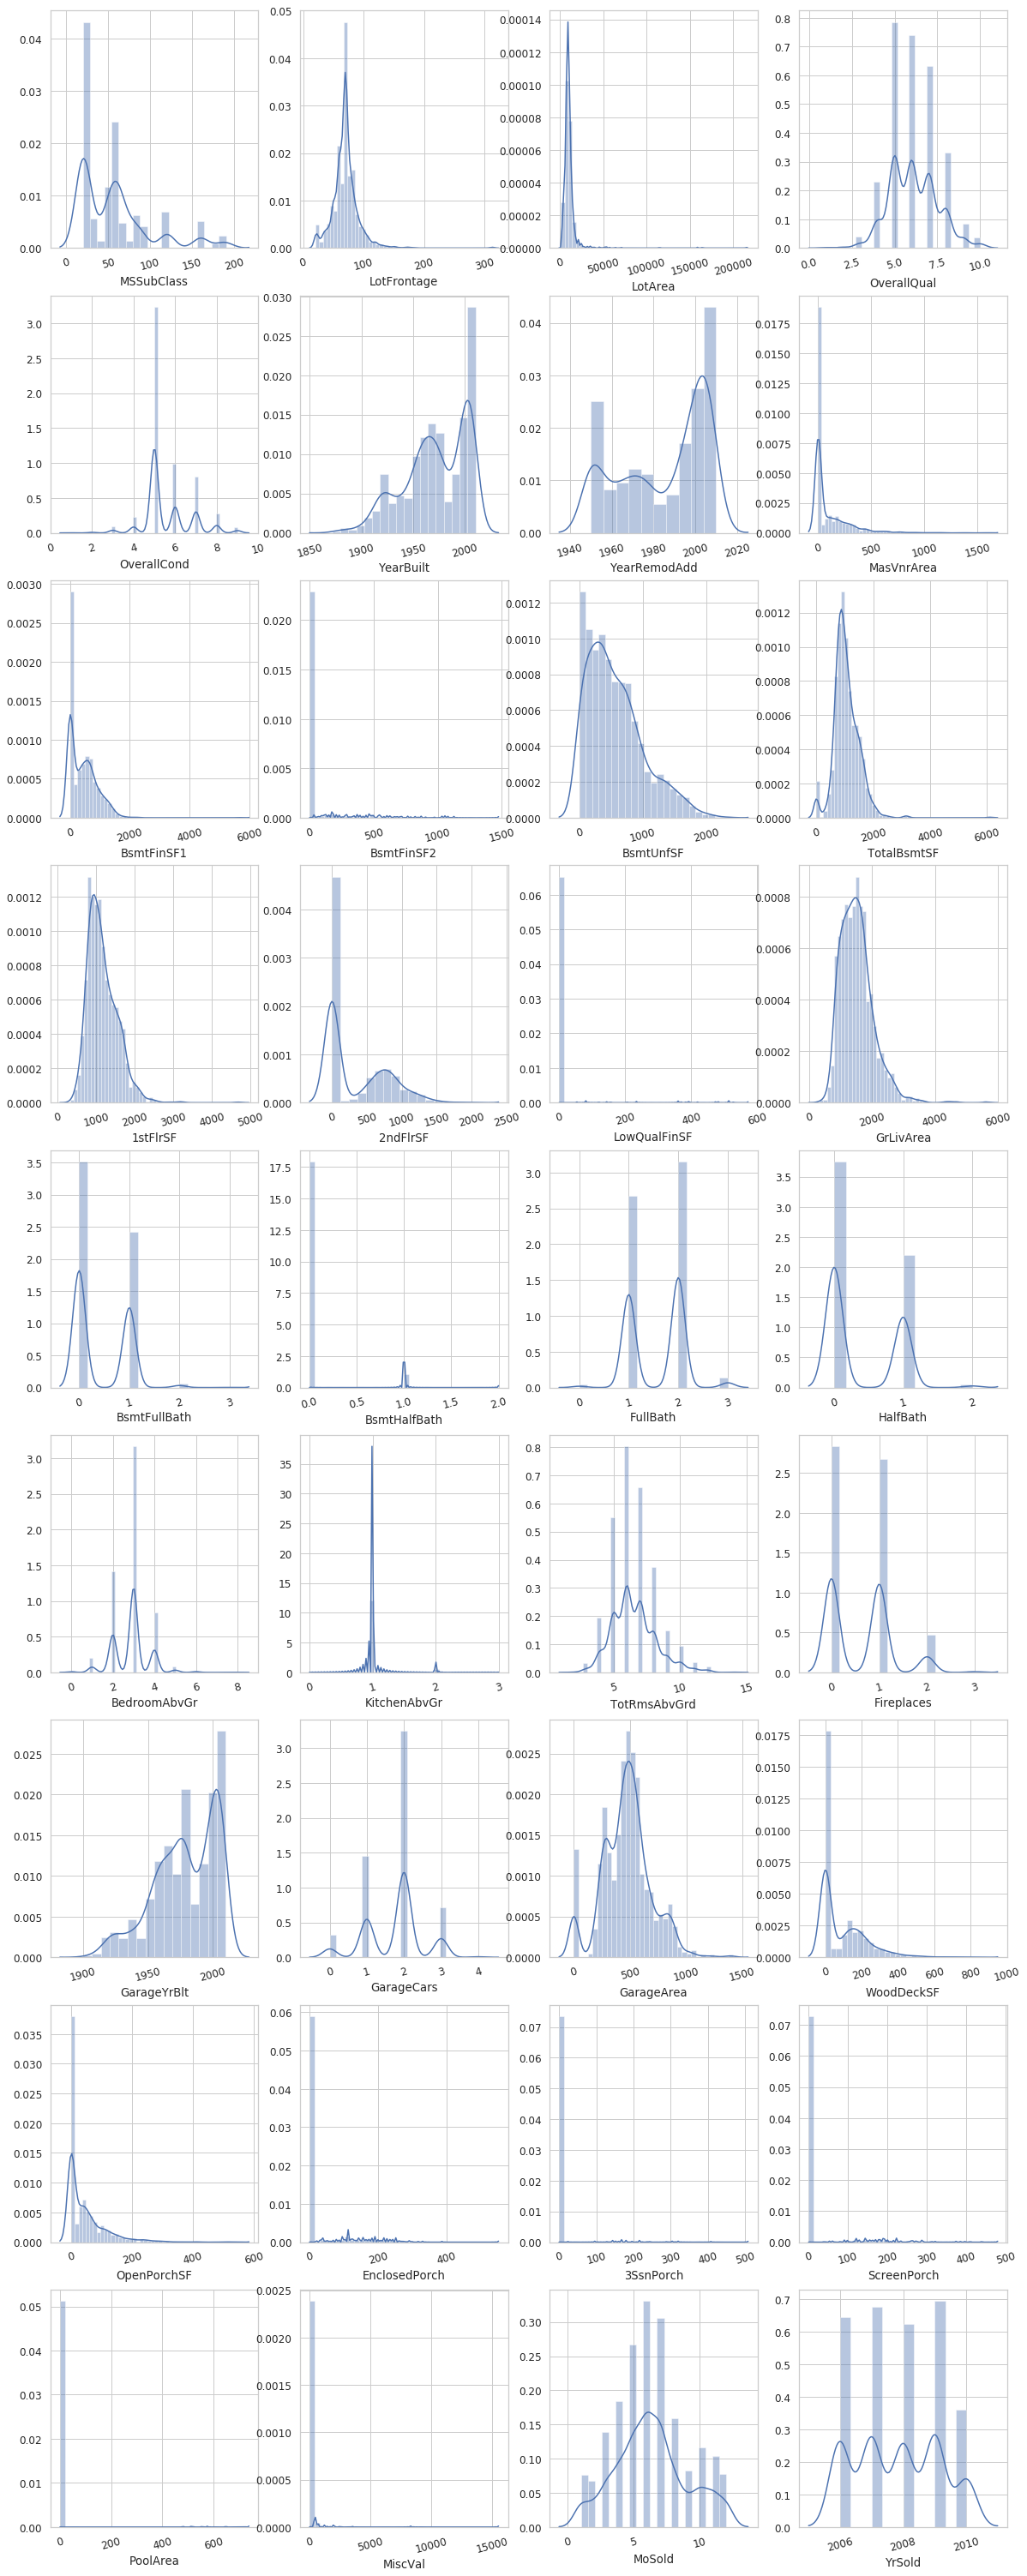

In [13]:
data_viz(train, cols = numeric_cols[1:38], plot_type = 'hist')

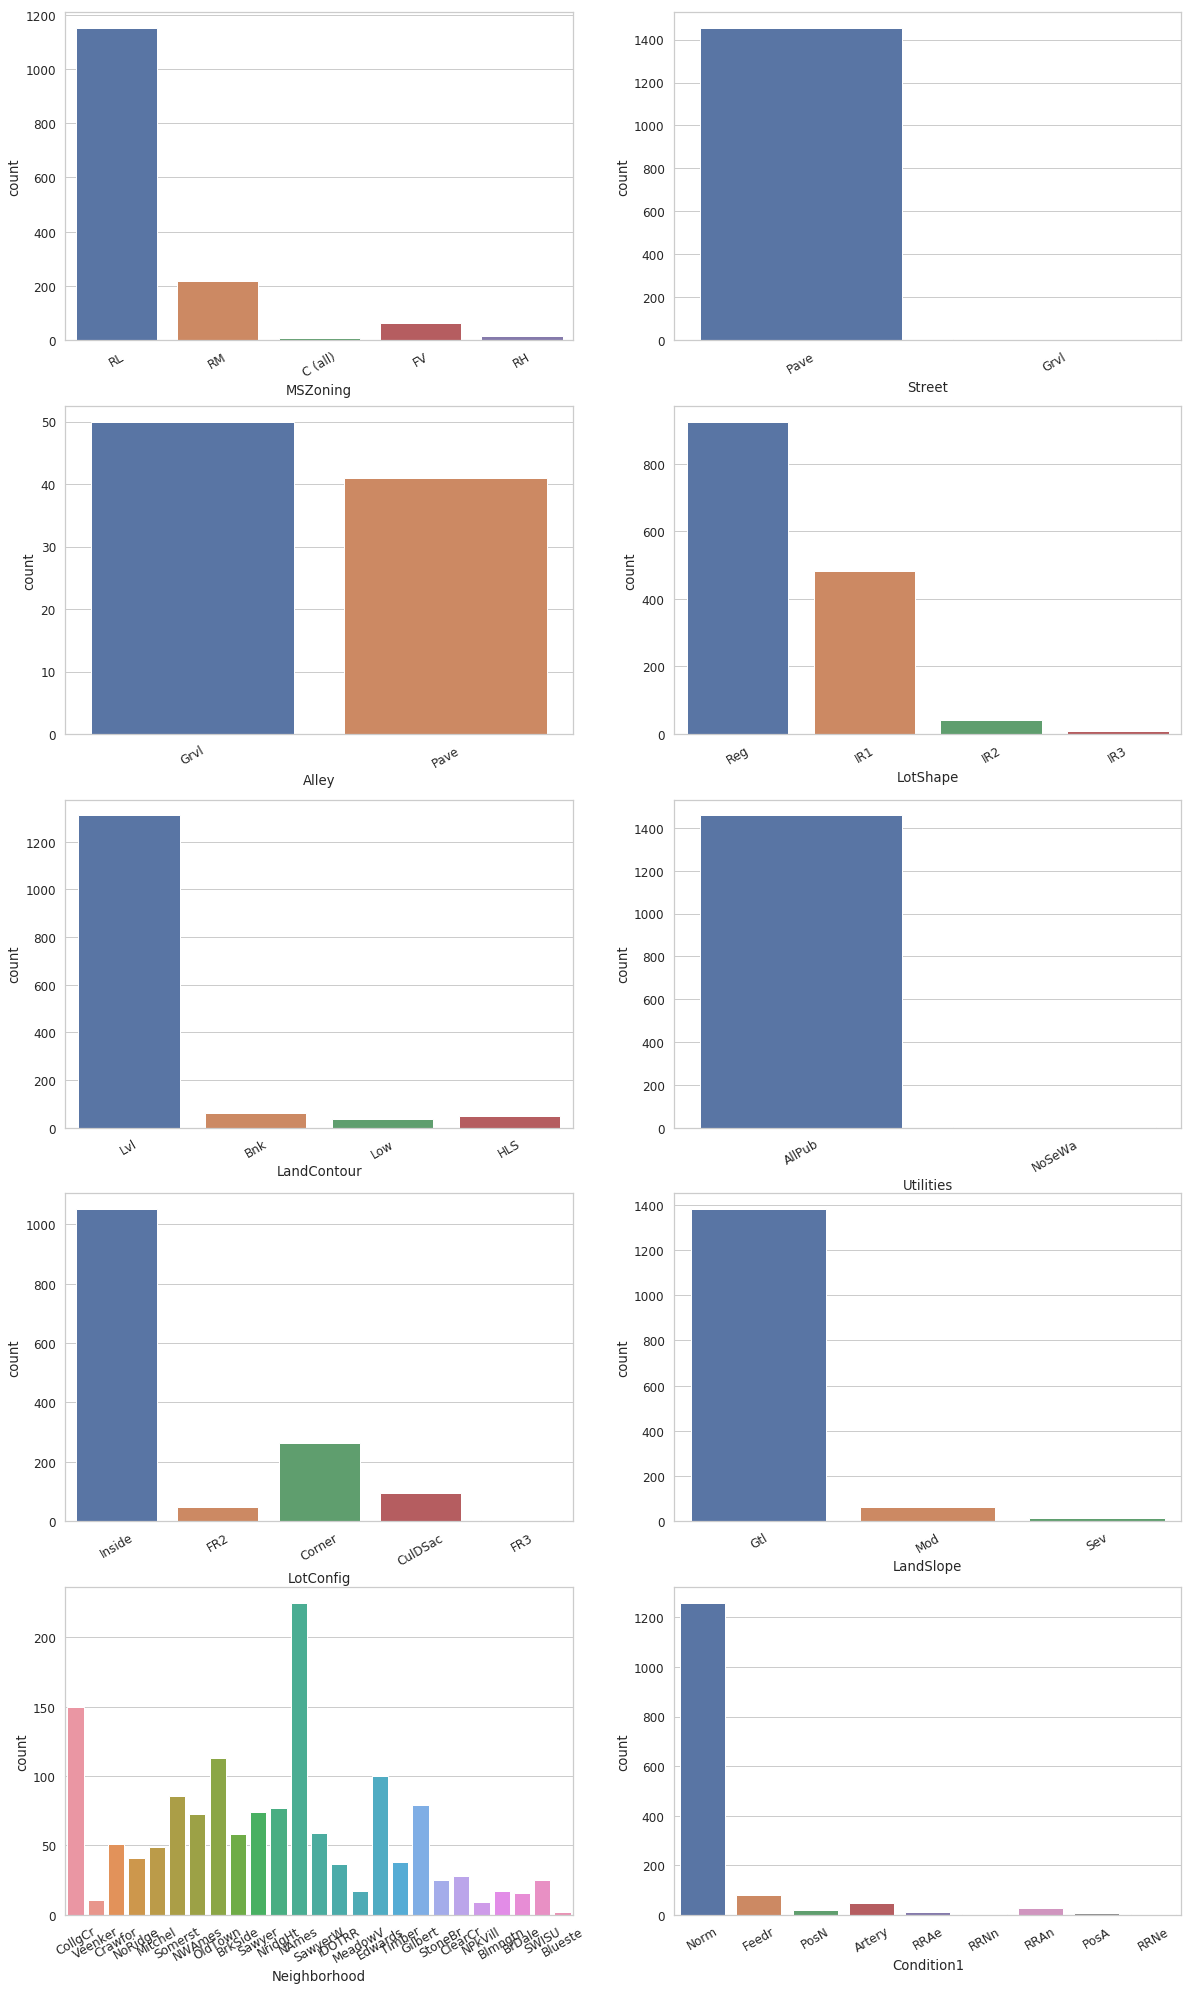

In [14]:
data_viz(train, cols = categorical_cols[0:10], plot_type = 'bar')

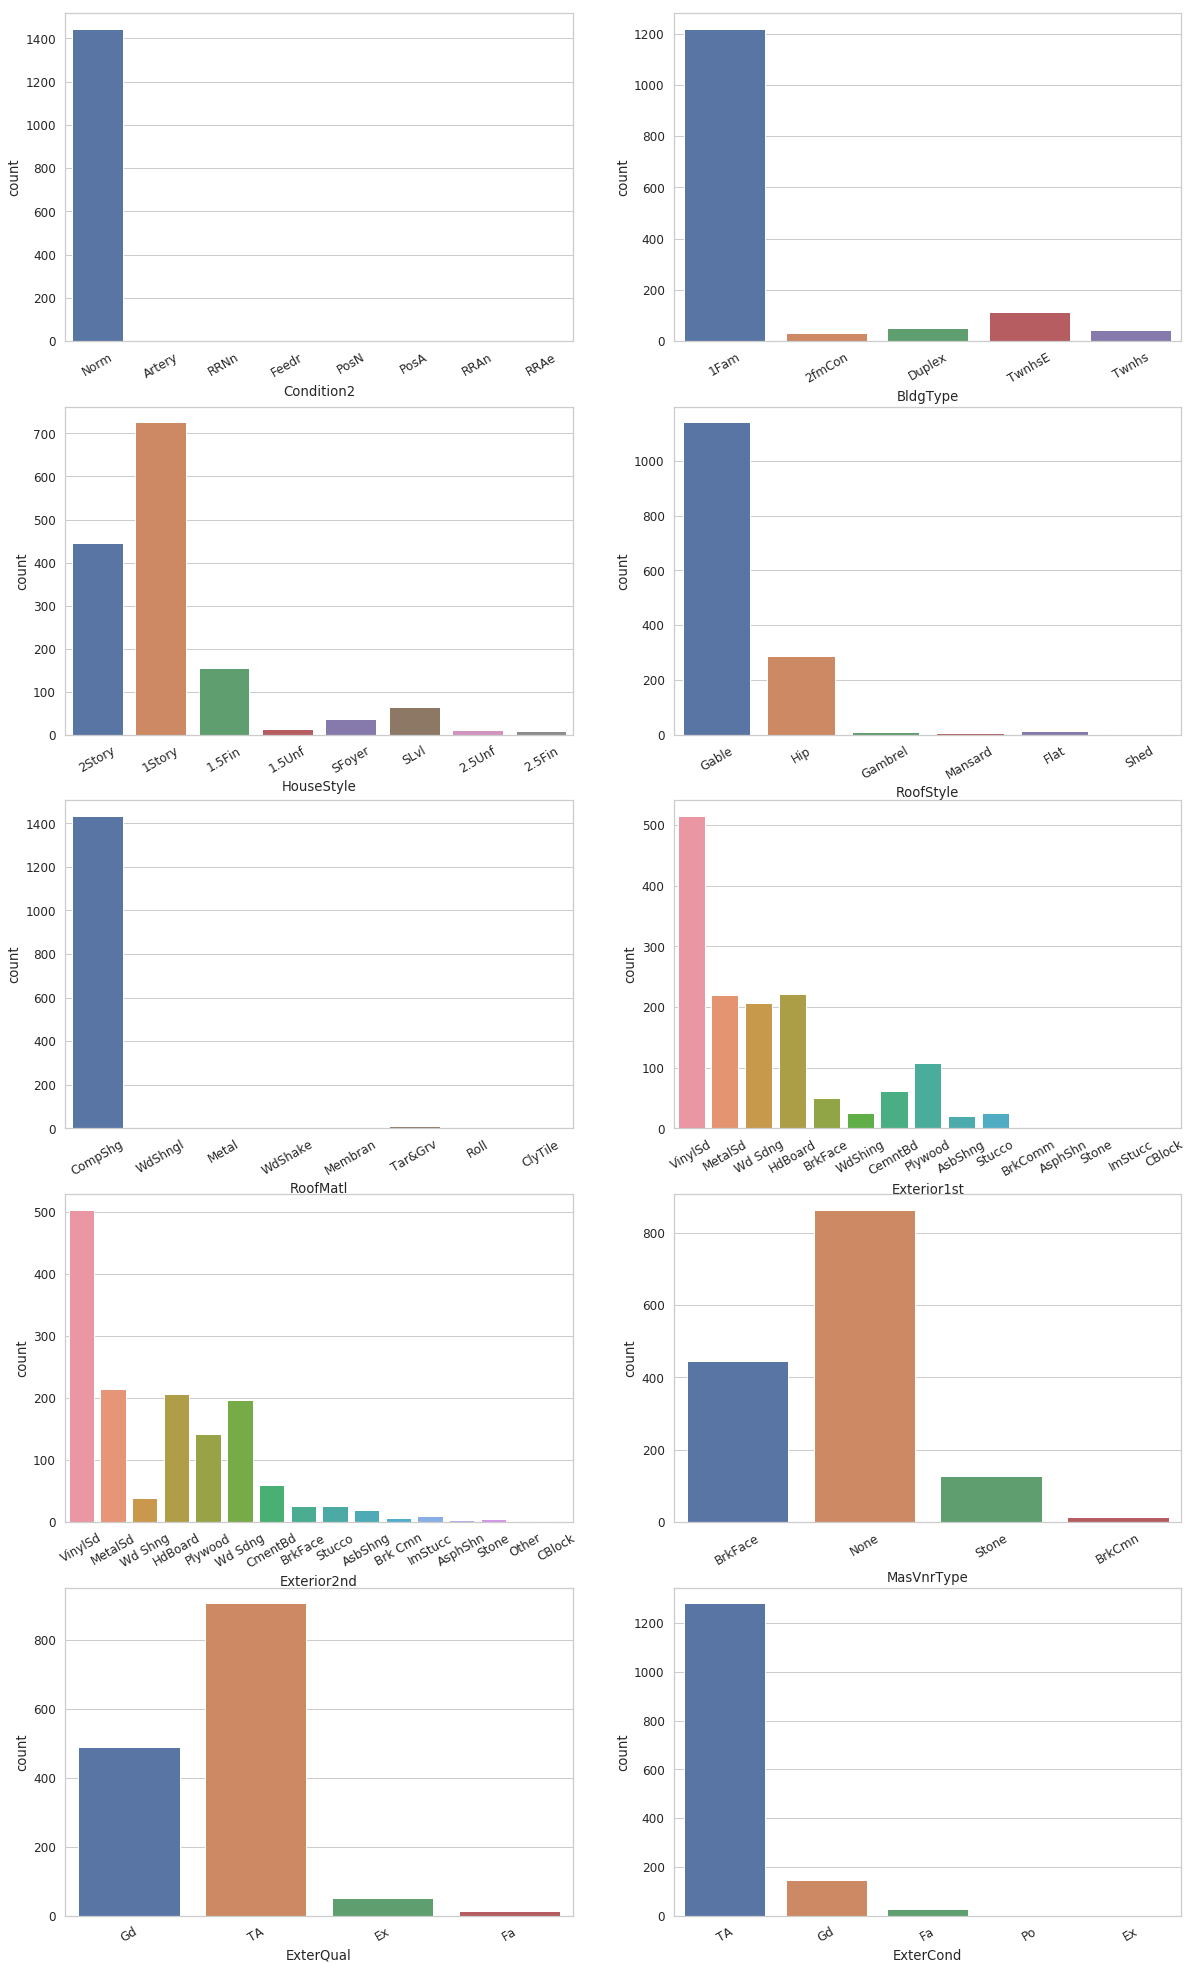

In [15]:
data_viz(train, cols = categorical_cols[10:20], plot_type = 'bar')

In [16]:
# data_viz(full_df, cols = categorical_cols[20:30], plot_type = 'bar')

In [17]:
# data_viz(full_df, cols = categorical_cols[30:40], plot_type = 'bar')

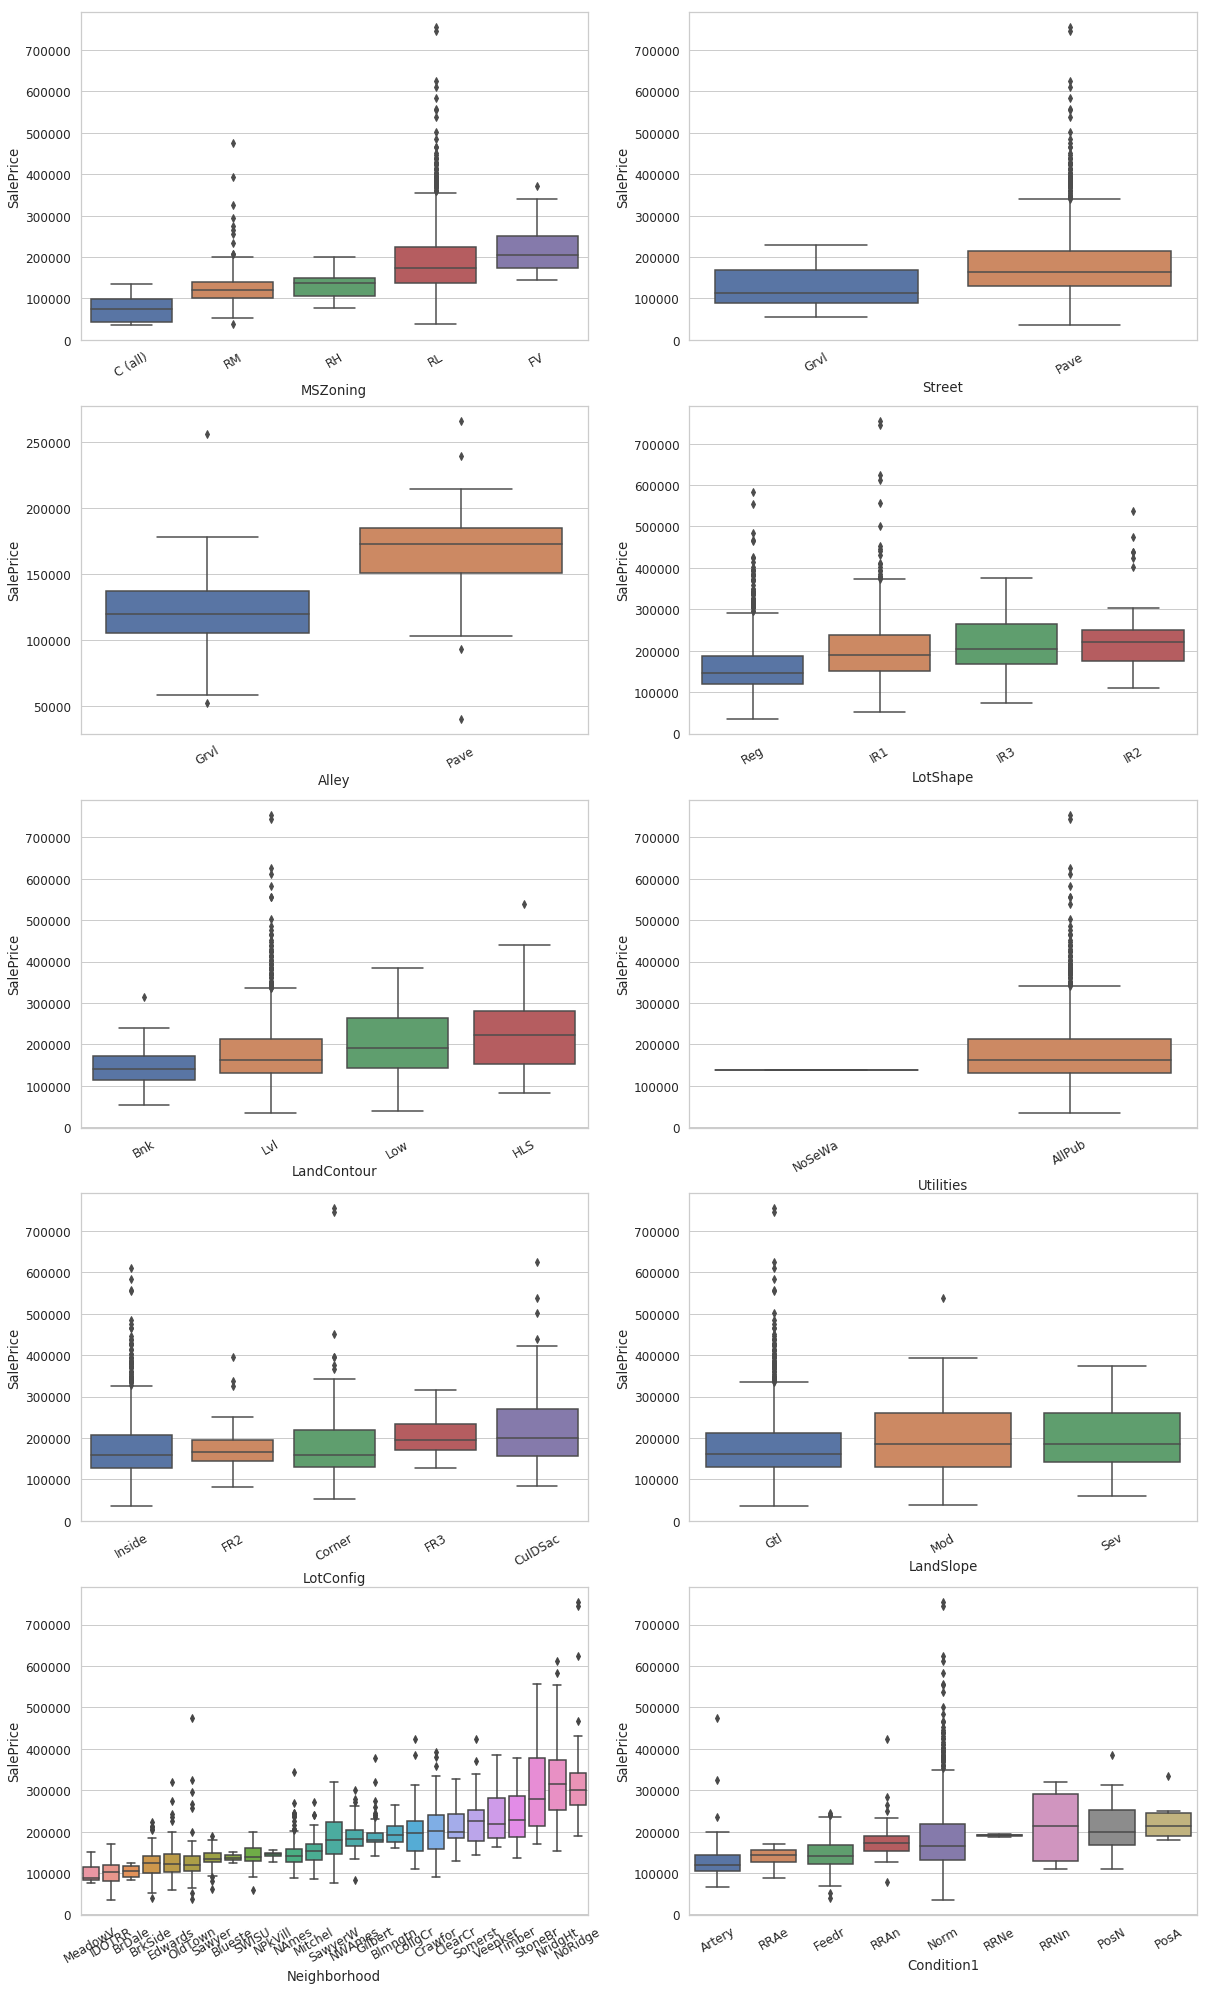

In [18]:
data_viz(train, cols = categorical_cols[0:10], target='SalePrice', plot_type = 'box')

### Feature Engineering

In [19]:
test['SalePrice'] = 0

In [20]:
train['is_train'] = 1
test['is_train'] = 0

##### Combine train and test into one dataframe

In [21]:
full_df = train.append(test)

#### Adding some features

In [22]:
full_df['Total_Bathrooms'] = full_df['FullBath'] + (0.5 * full_df['HalfBath']) + full_df['BsmtFullBath'] + (0.5 * full_df['BsmtHalfBath'])

full_df['PorchArea'] = full_df['OpenPorchSF'] + full_df['3SsnPorch'] + full_df['EnclosedPorch'] + full_df['ScreenPorch'] + full_df['WoodDeckSF']

full_df['TotalSF'] = full_df['TotalBsmtSF'] + full_df['GrLivArea'] + full_df['GarageArea'] + full_df['PorchArea'] + full_df['PoolArea']

full_df['SF_Per_Room'] = full_df['GrLivArea']/full_df['TotRmsAbvGrd']

In [23]:
full_df['haspool'] = np.where(full_df['PoolArea'] > 0, 1, 0)
full_df['has2ndfloor'] = np.where(full_df['2ndFlrSF'] > 0, 1, 0)
full_df['hasgarage'] = np.where(full_df['GarageArea'] > 0, 1, 0)
full_df['hasbsmt'] = np.where(full_df['TotalBsmtSF'] > 0, 1, 0)
full_df['hasfireplace'] = np.where(full_df['Fireplaces'] > 0, 1, 0)

In [24]:
#Transform date data
full_df['house_age'] = full_df['YrSold'] - full_df['YearBuilt']
full_df['remodel_age'] = full_df['YrSold'] - full_df['YearRemodAdd']
full_df['garage_age'] = full_df['YrSold'] - full_df['GarageYrBlt']

full_df['time_taken_to_remodel'] = full_df['YearRemodAdd'] - full_df['YearBuilt']
full_df['time_taken_to_garage'] = full_df['GarageYrBlt'] - full_df['YearBuilt']

full_df['same_yr_remodel'] = np.where(full_df['YearBuilt'] == full_df['YearRemodAdd'], 1, 0)
full_df['avg_house_year'] = (full_df['YrSold'] + full_df['YearRemodAdd'])/2

### Fix missing values

### Check for missing values

In [25]:
missing_stats = full_df.isnull().mean()
print(round(100 * missing_stats[missing_stats != 0],2))
print('\n')

MSZoning                 0.14
LotFrontage              7.78
Alley                   93.22
Utilities                0.07
Exterior1st              0.03
Exterior2nd              0.03
MasVnrType               0.82
MasVnrArea               0.51
BsmtQual                 2.77
BsmtCond                 2.81
BsmtExposure             2.81
BsmtFinType1             2.71
BsmtFinSF1               0.03
BsmtFinType2             2.74
BsmtFinSF2               0.03
BsmtUnfSF                0.03
TotalBsmtSF              0.03
Electrical               0.03
BsmtFullBath             0.07
BsmtHalfBath             0.07
KitchenQual              0.03
Functional               0.07
FireplaceQu             48.65
GarageType               5.38
GarageYrBlt              2.67
GarageFinish             5.45
GarageCars               0.03
GarageArea               0.03
GarageQual               5.45
GarageCond               5.45
PoolQC                  99.66
Fence                   80.44
MiscFeature             96.40
SaleType  

In [26]:
full_df = full_df[full_df.columns[full_df.isnull().mean() < 0.90]]

In [27]:
full_df.shape

(2919, 95)

In [28]:
full_df['Functional'] = full_df['Functional'].fillna('Typ')
full_df['Electrical'] = full_df['Electrical'].fillna("SBrkr")
full_df['KitchenQual'] = full_df['KitchenQual'].fillna("TA")

full_df['Exterior1st'] = full_df['Exterior1st'].fillna(full_df['Exterior1st'].mode()[0])
full_df['Exterior2nd'] = full_df['Exterior2nd'].fillna(full_df['Exterior2nd'].mode()[0])
full_df['SaleType'] = full_df['SaleType'].fillna(full_df['SaleType'].mode()[0])

In [29]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    full_df[col] = full_df[col].fillna(0)
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    full_df[col] = full_df[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full_df[col] = full_df[col].fillna('None')
    
for col in ('FireplaceQu', 'Fence', 'MasVnrType'):
    full_df[col] = full_df[col].fillna('None')

In [30]:
full_df.fillna(full_df.mean(), inplace=True)

### Encoding Categorical Data

In [31]:
full_df = pd.get_dummies(full_df)

### Transforming data back to train and test

In [32]:
train = full_df[full_df['is_train'] == 1]
test = full_df[full_df['is_train'] == 0]

In [33]:
train.shape, test.shape

((1460, 309), (1459, 309))

In [34]:
display_all(train.head())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,is_train,Total_Bathrooms,PorchArea,TotalSF,SF_Per_Room,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,house_age,remodel_age,garage_age,time_taken_to_remodel,time_taken_to_garage,same_yr_remodel,avg_house_year,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_E

### Final preprocessing steps

In [35]:
skip_cols = ['Id', 'is_train', 'SalePrice']

In [36]:
X = train.drop(skip_cols, axis=1)
y = train['SalePrice'].values

### Pipeline Step

In [37]:
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline(steps=[
                                  ('model', XGBRegressor(objective = 'reg:squarederror'
                                                         ,n_estimators=1000
                                                         ,learning_rate=0.03
                                                         ,random_state=0
                                                        )
                                  )
                                 ]
                         )

### Cross Validation Step

In [38]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(model_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [14360.17231646 16477.5787805  15088.12311376 13327.73971265
 15509.33339576]


In [39]:
print('Avg Score:', np.mean(scores))

Avg Score: 14952.589463827055


### General Model Fitting Step

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

In [41]:
XGB_model = XGBRegressor(n_estimators=1000
                         , objective = 'reg:squarederror'
                         , eval_metric = 'mae'
                         , learning_rate=0.03
                         , n_jobs=-1
                         , random_state = 0
                        )

In [42]:
XGB_model.fit(X_train, y_train, 
             early_stopping_rounds=100, 
             eval_set=[(X_valid, y_valid)], 
             verbose=200
             )

[0]	validation_0-mae:176099
Will train until validation_0-mae hasn't improved in 100 rounds.
[200]	validation_0-mae:16938.3
[400]	validation_0-mae:15930.5
[600]	validation_0-mae:15821.2
Stopping. Best iteration:
[591]	validation_0-mae:15814.4



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### Checking Predictions on Validation data

In [43]:
# get predicted prices on validation data
val_predictions = XGB_model.predict(X_valid)
print(mean_absolute_error(y_valid, val_predictions))

15814.389319349315


### Final Model On Full Train data

In [44]:
XGB_model.fit(X, y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [45]:
test_preds = XGB_model.predict(test.drop(skip_cols, axis=1))

In [46]:
output = pd.DataFrame({'Id': test.Id,
                      'SalePrice': test_preds
                      })

In [47]:
output.head()

,Id,SalePrice
0,1461,133028.984375
1,1462,165577.453125
2,1463,182081.765625
3,1464,190042.250000
4,1465,179289.437500
